# Neural Network Implementation - Anderw NG  ML course Exercise 4

In this exercise I craete a Neural Network that classify images of handwritten digits

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat  
%matplotlib inline


# load the data

data = loadmat('C:/Users/Home Premium/Desktop/ex3data1.mat')  
data  

X = data['X']  
y = data['y']  
X.shape, y.shape

((5000, 400), (5000, 1))

### Visualizing the data

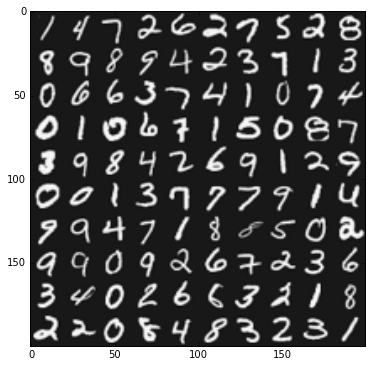

In [2]:
from IPython.display import Image
Image("C:\Users\Home Premium\Desktop/digits.png")

We're also going to need to one-hot encode our labels. One-hot encoding turns a class label nn (out of kk classes) into a vector of length kk where index nn is "hot" (1) while the rest are zero. Scikit-learn has a built in utility we can use for this.

In [3]:
from sklearn.preprocessing import OneHotEncoder  
encoder = OneHotEncoder(sparse=False)  
y_onehot = encoder.fit_transform(y)  
y_onehot.shape

(5000, 10)

In [4]:
y[0], y_onehot[0,:]

(array([10], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]))

The neural network we're going to build for this exercise has an input layer matching the size of our instance data (400 + the bias unit), a hidden layer with 25 units (26 with the bias unit), and an output layer with 10 units corresponding to our one-hot encoding for the class labels. The first piece we need to implement is a cost function to evaluate the loss for a given set of network parameters. The source mathematical function is in the exercise text, and looks pretty intimidating, but it helps to really break it down into pieces. Here are the functions required to compute the cost.

In [5]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

In [6]:
def forward_propagate(X, theta1, theta2):  
    m = X.shape[0]

    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 * theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [7]:
def cost(params, input_size, hidden_size, num_labels, X, y, learning_rate):  
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)

    J = J / m

    return J

We've used the sigmoid function before so that's not new. The forward-propagate function computes the hypothesis for each training instance given the current parameters (in other words, given some current state of the network and a set of inputs, it calculates the outputs at each layer in the network). The shape of the hypothesis vector (denoted by hh), which contains the prediction probabilities for each class, should match our one-hot encoding for y. Finally, the cost function runs the forward-propagation step and calculates the error of the hypothesis (predictions) vs. the true label for the instance.

We can test this real quick to convince ourselves that it's working as expected. Seeing the output from intermediate steps is also useful to understand what's going on.

In [8]:
# initial setup
input_size = 400  
hidden_size = 25  
num_labels = 10  
learning_rate = 1

# randomly initialize a parameter array of the size of the full network's parameters
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

m = X.shape[0]  
X = np.matrix(X)  
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))  
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [9]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)  
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

The cost function, after computing the hypothesis matrix hh, applies the cost equation to compute the total error between yy and hh.

In [10]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)

6.6720444350718022

Our next step is to add regularization to the cost function, which adds a penalty term to the cost that scales with the magnitude of the parameters. The equation for this looks pretty ugly, but it can be boiled down to just one line of code added to the original cost function. Just add the following right before the return statement.

J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2))) 

Next up is the backpropagation algorithm. Backpropagation computes the parameter updates that will reduce the error of the network on the training data. The first thing we need is a function that computes the gradient of the sigmoid function we created earlier.

In [11]:
def sigmoid_gradient(z):  
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

Now we're ready to implement backpropagation to compute the gradients. Since the computations required for backpropagation are a superset of those required in the cost function, we're actually going to extend the cost function to also perform backpropagation and return both the cost and the gradients. If you're wondering why I'm not just calling the existing cost function from within the backprop function to make the design more modular, it's because backprop uses a number of other variables calculated inside the cost function. Here's the full implementation. I skipped ahead and added gradient regularization rather than first create an un-regularized version.

In [12]:
def backprop(params, input_size, hidden_size, num_labels, X, y, learning_rate):  
    ##### this section is identical to the cost function logic we already saw #####
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)

    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)

    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term) # cross entropy function

    J = J / m

    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))

    ##### end of cost function logic, below is the new part #####

    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)

        d3t = ht - yt  # (1, 10)

        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)

        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t

    delta1 = delta1 / m
    delta2 = delta2 / m

    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2))) # np.ravel - Returns a contiguous flattened array

    return J, grad

There's a lot going on here so let's try to unpack it a bit. The first half of the function is calculating the error by running the data plus current parameters through the "network" (the forward-propagate function) and comparing the output to the true labels. The total error across the whole data set is represented as JJ. This is the part we discussed earlier as the cost function.

The rest of the function is essentially answering the question "how can I adjust my parameters to reduce the error the next time I run through the network"? It does this by computing the contributions at each layer to the total error and adjusting appropriately by coming up with a "gradient" matrix (or, how much to change each parameter and in what direction).

The hardest part of the backprop computation (other than understanding WHY we're doing all these calculations) is getting the matrix dimensions right, which is why I annotated some of the calculations with comments showing the resulting shape of the computation. By the way, if you find it confusing when to use A * B vs. np.multiply(A, B), you're not alone. Basically the former is a matrix multiplication and the latter is an element-wise multiplication (unless A or B is a scalar value, in which case it doesn't matter). I wish there was a more concise syntax for this (maybe there is and I'm just not aware of it).

Anyway, let's test it out to make sure the function returns what we're expecting it to.

In [13]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)  
J, grad.shape

(6.6774419521989223, (10285,))

In [14]:
from scipy.optimize import minimize

# minimize the objective function

fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size,num_labels, X, y_onehot, learning_rate),
               method='TNC', jac=True, options={'maxiter':250})

fmin

  status: 3
 success: False
    nfev: 250
     fun: 0.33822272000189735
       x: array([ -8.40161696e-01,   2.62232607e-04,   2.07554900e-04, ...,
        -3.09686093e-01,  -3.17935377e+00,   2.39963350e-01])
 message: 'Max. number of function evaluations reached'
     jac: array([  9.17537773e-05,   5.24465214e-08,   4.15109801e-08, ...,
         3.98113988e-04,   7.50482035e-05,   3.40832641e-04])
     nit: 21

We put a bound on the number of iterations since the objective function is not likely to completely converge. Our total cost has dropped below 0.5 though so that's a good indicator that the algorithm is working. Let's use the parameters it found and forward-propagate them through the network to get some predictions. We have to reshape the output from the optimizer to match the parameter matrix shapes that our network is expecting, then run the forward propagation to generate a hypothesis for the input data.

In [15]:
X = np.matrix(X)

theta1 = np.matrix(np.reshape(fmin.x[: hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))

theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)  

y_pred = np.array(np.argmax(h,axis=1) + 1)  # np.argmax - Returns the indices of the maximum values along an axis.

y_pred

array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]])

Finally we can compute the accuracy to see how well our trained network is doing.

In [16]:
correct = [1 if a == b else 0 for (a,b) in zip(y_pred, y)]

accuracy = (sum(map(int, correct)) / float(len(correct)))

print 'accuracy = {0}%'.format(accuracy * 100)

accuracy = 99.28%


 We've successfully implemented a rudimentary feed-forward neural network with backpropagation and used it to classify images of handwritten digits